### Libraries 

In [ ]:
import os, sys, glob
from datetime import datetime
import numpy as np
import string
from joblib import Parallel, delayed
import operator
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.model_selection import (RandomizedSearchCV, train_test_split, GridSearchCV, KFold, StratifiedShuffleSplit, 
                                    LeaveOneGroupOut, LeavePGroupsOut, cross_val_score, RepeatedKFold)
from sklearn.feature_selection import RFECV
from sklearn.neighbors import KernelDensity
import shap
from shaphypetune import BoostSearch, BoostRFE, BoostRFA, BoostBoruta
from xgboost import XGBRegressor
import xgboost as xgb
import pickle
from distinctipy import distinctipy

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()


In [9]:
local_path = '/media/amin/STORAGE/STORAGE/OneDrive/PhD/Landsat_BA'
data_shp_filter = pd.read_csv(f'{local_path}/Siberia/PeatFire/BG_CC/data/BackUp_data_20241101.csv', index_col='Unnamed: 0')
data_shp_filter

plot_id project_name treatment  burn_year  latitude  longitude  \
0    AK_KT.sf.2        AK_KT      burn       2003  65.58540 -144.71280   
1    AK_KT.sf.4        AK_KT      burn       2004  65.60290 -144.59120   
2    AK_KT.sf.5        AK_KT      burn       2004  65.52500 -145.24830   
3    AK_KT.sf.6        AK_KT      burn       2004  65.59180 -144.66510   
4    AK_KT.sf.3        AK_KT      burn       2003  62.69140 -141.53160   
..          ...          ...       ...        ...       ...        ...   
898      YE012B     SIB_Yert      burn       2018  62.08051  125.91018   
899      YE015B     SIB_Yert      burn       2018  61.95696  126.03944   
900      YE019B     SIB_Yert      burn       2018  61.96376  126.00948   
901      YE021B     SIB_Yert      burn       2018  61.96060  126.01952   
902      YE023B     SIB_Yert      burn       2018  61.95274  126.07643   

     ag_c_prefire  ag_c_combusted  prefire_sol  burn_depth  ...  PET_anomaly  \
0        -9999.00        -9999.00         27.0        13.7  ...     0.333694   
1        -9999.00        -9999.00         22.0         5.2  ...     2.032227   
2        -9999.00        -9999.00         25.5        16.0  ...     1.531294   
3        -9999.00        -9999.00         21.7        21.7  ...     2.030863   
4        -9999.00        -9999.00         18.4        14.0  ...     0.776472   
..            ...             ...          ...         ...  ...          ...   
898       3245.16          683.60         15.4         8.6  ...    -0.075239   
899       2484.64          814.55         14.6        12.2  ...    -0.113691   
900       2154.68          271.51         11.7         9.9  ...    -0.138474   
901       6477.50         1942.87         14.0        10.5  ...    -0.138474   
902       4738.10         1184.67         15.4        10.1  ...    -0.128319   

     AET_anomaly       ESI  diffET  ESI_anomaly  diffET_anomaly  DC_anomaly  \
0      -0.380511  0.500709 -538.00     0.229463       -0.428056   -0.398961   
1      -2.074631  0.322133 -757.75    -1.238437       -2.424703    2.254730   
2      -2.290121  0.285533 -705.25    -1.793899       -2.424620    2.008069   
3      -2.058405  0.321551 -758.75    -1.239764       -2.408611    2.182107   
4      -1.206751  0.628550 -365.50    -0.880155       -1.202347   -0.047029   
..           ...       ...     ...          ...             ...         ...   
898     0.495798  0.627567 -342.00     0.075897        0.376791    0.882978   
899     0.429882  0.627191 -347.50     0.077730        0.346777    0.882978   
900     0.479974  0.636005 -336.25     0.121803        0.391584    0.882978   
901     0.479974  0.636005 -336.25     0.121803        0.391584    0.882978   
902     0.417338  0.624630 -351.50     0.082923        0.344028    0.882978   

           SWE SWE_anomaly AGB  
0    17.333333   -1.298072  13  
1    19.333333   -1.087281  36  
2    20.333333   -0.558124  50  
3    19.000000   -1.114116   6  
4    40.666667   -0.872917  33  
..         ...         ...  ..  
898  55.000000   -0.330112  52  
899  53.333333   -0.377797  28  
900  53.000000   -0.356094  30  
901  53.000000   -0.356094  51  
902  51.333333   -0.357121   7  

[896 rows x 109 columns]

In [7]:
data_shp_filter.columns

Index(['plot_id', 'project_name', 'treatment', 'burn_year', 'latitude',
       'longitude', 'ag_c_combusted', 'burn_depth', 'bg_c_combusted',
       'total_c_combusted', 'TILE', 'zone', 'near_longitude', 'near_latitude',
       'JD', 'patch_id', 'BA_patch', 'duration', 'BA_grid', 'sand', 'silt',
       'clay', 'FRP', 'SOC', 'bog', 'fen', 'post_NBR', 'post_NBR2', 'diff_NBR',
       'diff_NBR2', 'elevation', 'aspect', 'slope', 'tree_cover',
       'nontree_cover', 'Tmax', 'Tmax_anomaly', 'Tmin', 'Tmin_anomaly', 'VPD',
       'VPD_anomaly', 'solar_down', 'solar_down_anomaly', 'PDSI',
       'PDSI_anomaly', 'CWD', 'CWD_anomaly', 'snow', 'snow_anomaly',
       'moisture', 'moisture_anomaly', 'DC', 'DMC', 'FFMC', 'FWI',
       'DC_anomaly', 'DMC_anomaly', 'FFMC_anomaly', 'FWI_anomaly', 'LST',
       'LST_anomaly', 'LST_persistence', 'AGB', 'pred_agcc', 'pred_depth',
       'pred_bgc'],
      dtype='object')

## Modelling

<AxesSubplot: >

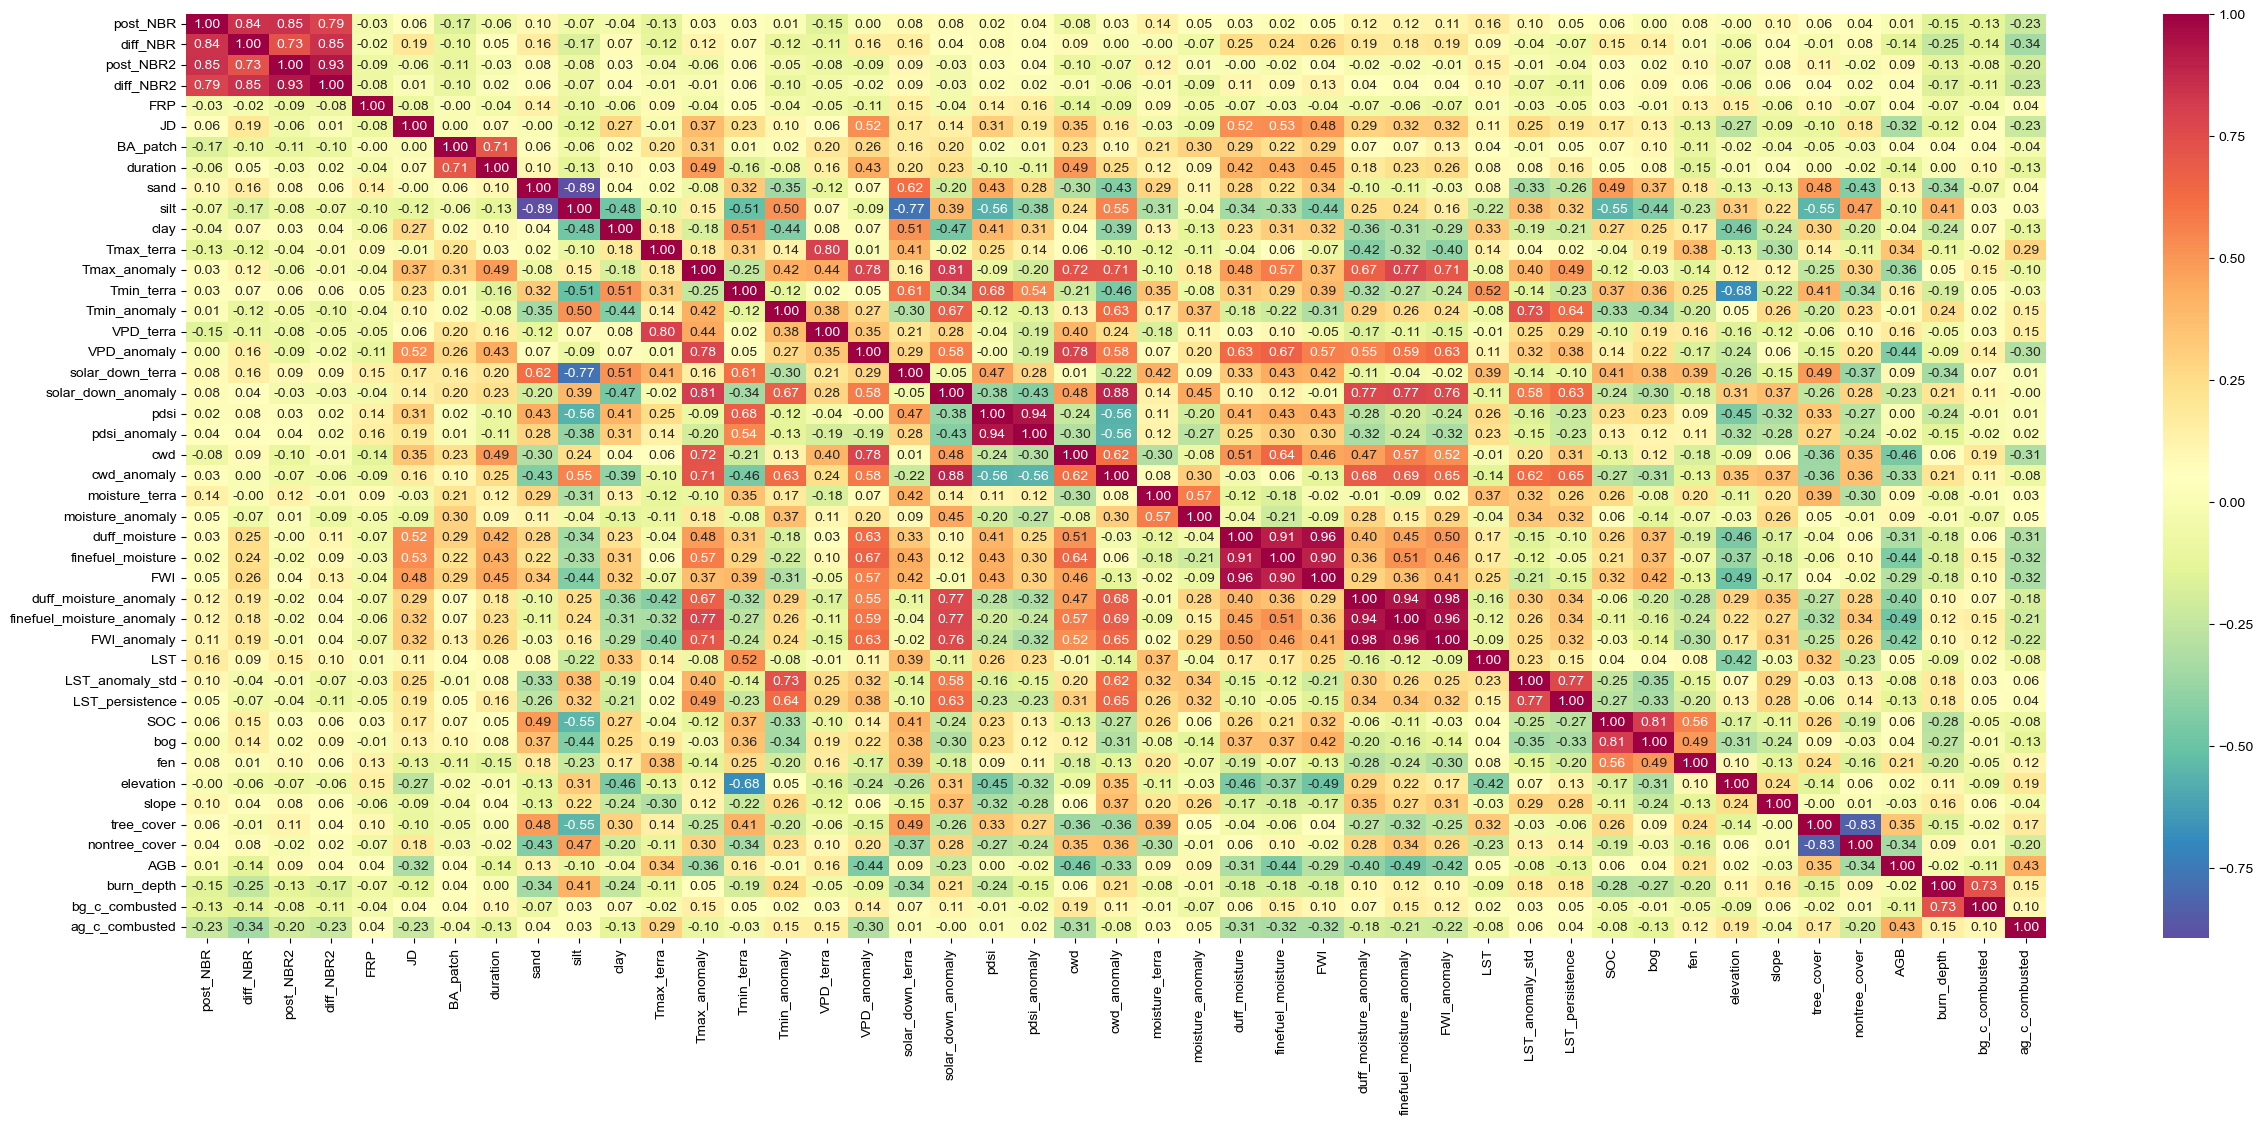

In [10]:
clim = [
 'Tmax_terra',
 'Tmax_anomaly',
 'Tmin_terra',
 'Tmin_anomaly',
 'VPD_terra',
 'VPD_anomaly',
 'solar_down_terra',
 'solar_down_anomaly',
 'pdsi',
 'pdsi_anomaly',
 'cwd',
 'cwd_anomaly',
'moisture_terra',
 'moisture_anomaly',
 'duff_moisture',
 'finefuel_moisture',
 'FWI',
 'duff_moisture_anomaly',
 'finefuel_moisture_anomaly',
 'FWI_anomaly',
]

fig, ax = plt.subplots(figsize=(30, 12))
variables = ['post_NBR', 'diff_NBR', 
             'post_NBR2', 'diff_NBR2', 
               'FRP', 'JD', 'BA_patch', 'duration', 'sand', 'silt', 'clay', 
                *clim,
               'LST', 'LST_anomaly_std', 'LST_persistence',
               'SOC', 'bog', 'fen', 'elevation', 'slope', 
               'tree_cover', 'nontree_cover', 'AGB',
                'burn_depth', 'bg_c_combusted', 'ag_c_combusted']
# correlations
data = data_shp_filter[variables].apply(pd.to_numeric)
# data = data.loc[data_shp_filter.burn_year!=2002]
corrMatrix = data.query('ag_c_combusted >= 0').corr(method='pearson')
sns.heatmap(corrMatrix, annot=True, fmt='.02f', cmap='Spectral_r')

# plt.savefig(f'{local_path}/Siberia/Plots/Correlation_Matrix.jpeg', 
#                dpi= 500, bbox_inches='tight', pad_inches=1*1/2.54)

In [12]:
data = data_shp_filter[variables].apply(pd.to_numeric)
data_AG = data.copy().query('ag_c_combusted >= 0 & ag_c_combusted < 5000').drop(columns=['bg_c_combusted', 'burn_depth'])
data = data.drop(columns=['ag_c_combusted', 'AGB'])
data_AG

post_NBR  diff_NBR  post_NBR2  diff_NBR2         FRP   JD      BA_patch  \
139   -0.5244  -1.01190    -0.0584   -0.37950   15.000000  148  8.528164e+07   
140   -0.2929  -0.80175     0.0739   -0.22335   23.222221  148  8.528164e+07   
141   -0.5008  -1.11900    -0.0434   -0.36830   16.013987  149  8.528164e+07   
142   -0.1971  -0.81570     0.0423   -0.28260   16.013987  149  8.528164e+07   
143   -0.5358  -1.11530    -0.0859   -0.40790    5.400000  235  9.008847e+05   
..        ...       ...        ...        ...         ...  ...           ...   
898   -0.1301  -0.67230     0.1305   -0.23045   26.702658  195  8.928545e+08   
899   -0.2895  -0.79740     0.0877   -0.25895  242.659576  201  8.928545e+08   
900   -0.3195  -0.84035     0.0146   -0.33035   15.789474  201  8.928545e+08   
901   -0.2400  -0.70090     0.0836   -0.23230   15.789474  201  8.928545e+08   
902   -0.4879  -0.82150    -0.0612   -0.35745    8.450705  196  8.928545e+08   

     duration        sand        silt  ...  LST_persistence  SOC  bog  fen  \
139         5  282.666667  628.333333  ...         0.133333   13    2    0   
140         5  290.000000  617.666667  ...         0.187500    9    2    0   
141         5  295.333333  613.000000  ...         0.312500    9    2    0   
142         5  287.666667  613.666667  ...         0.312500    9    2    0   
143         3  310.666667  596.000000  ...         0.266667    9    2    0   
..        ...         ...         ...  ...              ...  ...  ...  ...   
898        45  477.000000  300.000000  ...         0.375000   33    1    0   
899        45  471.333333  309.666667  ...         0.375000   46    2    0   
900        45  494.333333  292.000000  ...         0.437500   46    2    0   
901        45  492.000000  299.333333  ...         0.437500   46    2    0   
902        45  488.333333  286.333333  ...         0.312500   46    2    0   

     elevation     slope  tree_cover  nontree_cover  AGB  ag_c_combusted  
139        363  2.332499          20             49   95        1414.520  
140        360  0.927410          15             51  128         809.064  
141        391  0.927410          18             58   94         604.351  
142        393  2.140705          17             57  104         395.631  
143        373  1.854334          17             52   83         445.372  
..         ...       ...         ...            ...  ...             ...  
898        240  1.979994          33             42   52         683.600  
899        226  0.927410          27             50   28         814.550  
900        245  2.179313          32             53   30         271.510  
901        246  2.179134          39             50   51        1942.870  
902        223  1.854334          33             42    7        1184.670  

[586 rows x 43 columns]

In [13]:
df = data.copy().sort_values(by=['burn_depth'], ascending=True)
df = df.reset_index(drop=True)
X, y = df.loc[:, df.columns[:-2]], df[df.columns[-2]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)
X_train

post_NBR  diff_NBR  post_NBR2  diff_NBR2          FRP   JD      BA_patch  \
736   -0.4161  -0.87620    -0.0258   -0.31780    15.000000  199  1.330314e+09   
382   -0.0462  -0.43010     0.0991   -0.20930    60.306122  193  1.181457e+08   
706   -0.3711  -0.72565     0.0059   -0.27835     9.829060  183  5.097121e+08   
817   -0.1377  -0.51460     0.0174   -0.26830     8.750000  177  3.108321e+09   
118   -0.5132  -1.15370    -0.0648   -0.43940    11.948052  198  2.103933e+07   
..        ...       ...        ...        ...          ...  ...           ...   
106   -0.4178  -0.74055    -0.1131   -0.39265  2988.125000  179  1.022062e+09   
270   -0.3805  -0.96450     0.0374   -0.33225   156.328323  191  1.965800e+09   
860   -0.2316  -0.74590     0.0572   -0.27410    32.599998  236  1.798731e+08   
435   -0.3204  -0.73965     0.0425   -0.29735    18.630953  179  2.121793e+09   
102   -0.1558  -0.60595     0.1477   -0.12690    18.400000  214  1.238704e+08   

     duration        sand        silt  ...         LST  LST_anomaly_std  \
736        76  284.000000  583.666667  ...  278.037500         0.399848   
382        53  557.000000  297.333333  ...  278.647500         0.234920   
706        46  407.333333  395.000000  ...  280.725000         0.013295   
817        83  325.333333  553.333333  ...  276.832500         0.905930   
118         7  334.666667  290.000000  ...  279.725000        -0.342624   
..        ...         ...         ...  ...         ...              ...   
106        18  552.333333  305.000000  ...  281.062500         0.158189   
270        52  509.666667  243.666667  ...  282.283750         1.289505   
860        21  285.333333  597.333333  ...  283.497333         2.909968   
435        44  358.666667  492.666667  ...  277.567500         0.876065   
102         7  522.000000  242.666667  ...  281.376250        -0.073054   

     LST_persistence  SOC  bog  fen  elevation      slope  tree_cover  \
736         0.375000   20    1    0        723   4.589505          19   
382         0.375000  177   13    1        373   2.819594          26   
706         0.312500   63   16    4        228   3.815661          34   
817         0.615385   30    2    0        803   8.249976           9   
118         0.500000  200   15    2        280   1.900955          55   
..               ...  ...  ...  ...        ...        ...         ...   
106         0.312500   98    4    3        665   2.780289          31   
270         0.500000  174   11    1        122   3.704792          53   
860         0.600000   24    1    0        301  26.678127          59   
435         0.500000   36    3    0        748   9.451172          15   
102         0.312500  327   15    9        463   1.852368          38   

     nontree_cover  
736             60  
382             52  
706             41  
817             55  
118              8  
..             ...  
106             49  
270             14  
860             23  
435             59  
102             40  

[716 rows x 41 columns]

In [ ]:
fig, ax = plt.subplots(len(np.unique(df.cluster)), 1, figsize=(30, 12*len(np.unique(df.cluster))))
for i, (p, c) in enumerate(np.column_stack(np.unique(df.cluster, return_counts=True))):
    mask = df.cluster == p
    corrMatrix = df.loc[mask].corr(method='pearson')
    sns.heatmap(corrMatrix, annot=True, fmt='.02f', cmap='Spectral_r', ax=ax[i]);
    ax[i].set_title(f'Cluster: {p}, {c} sites', size=20)

## 2. XGB hyperopt

### 2.1. Hyperparameters setting

In [ ]:
      
hopt_space={'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
        'max_depth': hp.randint('max_depth', 3, 18),
        'subsample': hp.uniform('subsample', 0.5, 1),
        'gamma': hp.uniform ('gamma', 0, 10),
        'reg_alpha' : hp.uniform('reg_alpha', 0, 20),
        'reg_lambda' : hp.uniform('reg_lambda', 0, 20),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        }

In [ ]:
def create_splits(index, n=100, tr=0.8, seed=42):
    np.random.seed(seed)
    s = np.random.choice(1000, n, replace=False)
    splits = []
    for seed in s:
        np.random.seed(seed)
        np.random.shuffle(index)
        lim = int(tr*len(index))
        splits.append([index[:lim], index[lim:]])
    return splits
    
def runcv(model, X0, y0, f):
    X_train_cv, X_valid_cv = X0.iloc[f[0]], X0.iloc[f[1]]
    y_train_cv, y_valid_cv = y0.iloc[f[0]], y0.iloc[f[1]]
    model.fit(X_train_cv, y_train_cv, 
              eval_set=[(X_valid_cv, y_valid_cv)], 
              early_stopping_rounds=50, verbose=0)
    preds = model.predict(X_valid_cv)
    rmse = metrics.mean_squared_error(y_valid_cv, preds, squared=False)
    return rmse

def r2_score_xgb(preds, dmatrix):
    labels = dmatrix.get_label()
    ss_res = ((labels - preds) ** 2).sum()
    ss_tot = ((labels - labels.mean()) ** 2).sum()
    r2 = 1 - ss_res / ss_tot
    return 'r2', float(r2)
    
def mae_score_xgb(preds, dmatrix):
    labels = dmatrix.get_label()
    mae = np.mean(np.abs(preds - labels))
    return "mae", mae

def rmse_score_xgb(preds, dmatrix):
    labels = dmatrix.get_label()
    rmse = np.sqrt(np.mean((preds - labels) ** 2))
    return "rmse", rmse

def objective(params, return_history=False):
    n = 1000
    print(params)
    params.update({"objective": "reg:squarederror", 
              'tree_method':'hist',
              'device': 'cuda', 
              #  'updater': 'grow_gpu_hist',        # GPU-enabled updater
              'nthread': 16,
              # 'eval_metric':'rmse',
              # 'n_jobs': 18
                  })
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(y.values.reshape(-1, 1))
    density = np.exp(kde.score_samples(y.values.reshape(-1, 1)))
    weights = 1.0 / density
   
    min_features = 10
    remaining_features = list(X.columns)
    hist_rmse = []
    hist_feat = []
    while len(remaining_features) >= min_features: #and (ini_rmse > avrg_rmse):
        # ini_rmse = avrg_rmse
        print(f'Fitting with {len(remaining_features)} features')
        dmatrix = xgb.DMatrix(X[remaining_features], label=y, weight=weights)
        xgb_cv = xgb.cv(params, dmatrix, num_boost_round=n, folds=kf, 
                        early_stopping_rounds=50, 
                        seed=42, verbose_eval=0,
                        # custom_metric=r2_score_xgb,  # custom R² metric   
                        # maximize=True
                       )
        avrg_rmse = xgb_cv.loc[:, 'test-rmse-mean'].values.min()
        hist_rmse.append(avrg_rmse)
        hist_feat.append(remaining_features.copy())
        model = xgb.train(
            params=params,
            dtrain=dmatrix,
            num_boost_round=xgb_cv.shape[0]  # Use optimal number of rounds from CV
        )
        
        ## Get feature importances
        feature_importances = model.get_score(importance_type='gain')
        least_important_feature = min(feature_importances, key=feature_importances.get)

        print(f"Removing least important feature: {least_important_feature}, RMSE: {avrg_rmse}")
        remaining_features.remove(least_important_feature)  

    avrg_rmse = np.min(hist_rmse)
    selected_features = hist_feat[np.argmin(hist_rmse)]

    
    print(f'{len(selected_features)} features left with rmse {avrg_rmse}: {selected_features}')

    if return_history:
        dmatrix = xgb.DMatrix(X[selected_features], label=y, weight=weights)
        params.update({'eval_metric':['rmse', 'mae']})
        xgb_cv = xgb.cv(params, dmatrix, num_boost_round=1000, folds=kf, 
                        early_stopping_rounds=50, 
                        seed=42, verbose_eval=50,
                        custom_metric=r2_score_xgb,
                        maximize=True
                       )
        idx = np.argmin(xgb_cv.loc[:, 'test-rmse-mean'].values)
        evals = dict(xgb_cv.loc[idx, ['test-r2-mean', 'test-rmse-mean', 'test-mae-mean']])
        n_boost = xgb_cv.shape[0]
            
        return {'n_boost': n_boost, **evals, 'features': selected_features}
    else:
        return {'loss': avrg_rmse, 'status': STATUS_OK,
               'params': params}


In [8]:
np.random.seed(42)
df = data.copy().sort_values(by=['burn_depth'], ascending=True)
df = df.reset_index(drop=True)
X, y = df.loc[:, df.columns[:-2]], df[df.columns[-2]]
trials = Trials()
# Run hyperopt's fmin to minimize the objective
best_depth_hopt_RFECV200 = fmin(
    fn=objective,  # The objective function
    space=hopt_space,  # The hyperparameter search space
    algo=tpe.suggest,  # The optimization algorithm (Tree-structured Parzen Estimator)
    max_evals=200,  # Number of iterations for optimization
    trials=trials,  # Store trials for evaluation
    rstate=np.random.RandomState(42)  # Seed for reproducibility
)


{'colsample_bytree': 0.931370806570153, 'gamma': 5.114013866515924, 'learning_rate': 0.0804317609892207, 'max_depth': 15, 'min_child_weight': 3.0, 'reg_alpha': 1.3810268174720841, 'reg_lambda': 16.652640646299194, 'subsample': 0.7273505261106861}
Fitting with 42 features                               
Removing least important feature: pdsi_anomaly, RMSE: 3.187662458622719, R2: 0.6482623999999999
Fitting with 41 features                               
Removing least important feature: FWI_anomaly, RMSE: 3.195877936566988, R2: 0.6463331
Fitting with 40 features                               
Removing least important feature: solar_down_anomaly, RMSE: 3.1881626174960624, R2: 0.6483768000000001
Fitting with 39 features                               
Removing least important feature: finefuel_moisture_anomaly, RMSE: 3.1803866070231073, R2: 0.6499022999999999
Fitting with 38 features                               
Removing least important feature: duff_moisture_anomaly, RMSE: 3.1891850090442

In [ ]:
with open(f'{local_path}/Siberia/PeatFire/BG_CC/data/trials_depth.pkl', 'wb') as f:
    pickle.dump(trials, f)

In [15]:
trials = pickle.load(open(f'{local_path}/Siberia/PeatFire/BG_CC/data/trials_depth.pkl', 'rb'))
best_depth_hopt_RFECV200 = trials.argmin
best_depth_hopt_RFECV200

{'colsample_bytree': 0.8583066583623611,
 'gamma': 0.25202534307914415,
 'learning_rate': 0.04654086605752556,
 'max_depth': 13,
 'min_child_weight': 5.0,
 'reg_alpha': 1.6986609580956173,
 'reg_lambda': 15.760638486284062,
 'subsample': 0.6056058096420451}

In [8]:
best_depth_hopt_RFECV200 = {"objective": "reg:squarederror", 
              'tree_method':'hist',
              'device': 'cuda', 
                'colsample_bytree': 0.8583066583623611,
   'gamma': 0.25202534307914415,
   'learning_rate': 0.02654086605752556,
   'max_depth': 13,
   'min_child_weight': 5.0,
   'reg_alpha': 1.6986609580956173,
   'reg_lambda': 15.760638486284062,
   'subsample': 0.6056058096420451,}

In [ ]:
np.random.seed(42)
df = data.copy().sort_values(by=['burn_depth'], ascending=True)
df = df.reset_index(drop=True)
X, y = df.loc[:, df.columns[:-2]], df[df.columns[-2]]
# for i, p in enumerate(a):
#     print(f'****** {i}\n')
history_depth = objective(best_depth_hopt_RFECV200, return_history=True)

{'colsample_bytree': 0.7497454873245625, 'gamma': 2.221517984805588, 'learning_rate': 0.17607434585022883, 'max_depth': 3, 'min_child_weight': 7.0, 'reg_alpha': 10.211604470213945, 'reg_lambda': 9.371351701482075, 'subsample': 0.5830550130796912, 'objective': 'reg:squarederror', 'tree_method': 'hist', 'device': 'cuda', 'nthread': 16}
Fitting with 39 features
Removing least important feature: pdsi_anomaly, RMSE: 6.26276645381755
Fitting with 38 features
Removing least important feature: LST, RMSE: 6.361989427149949
Fitting with 37 features
Removing least important feature: sand, RMSE: 6.202135584173974
Fitting with 36 features
Removing least important feature: pdsi, RMSE: 6.097010654079698
Fitting with 35 features
Removing least important feature: finefuel_moisture, RMSE: 6.251432312751818
Fitting with 34 features
Removing least important feature: FWI_anomaly, RMSE: 6.425688793560956
Fitting with 33 features
Removing least important feature: finefuel_moisture_anomaly, RMSE: 6.2630170743

In [12]:
history_depth

{'n_boost': 230,
 'test-r2-mean': 0.2690715,
 'test-rmse-mean': 6.097010654079698,
 'test-mae-mean': 4.826579695327967,
 'features': ['post_NBR',
  'diff_NBR',
  'post_NBR2',
  'diff_NBR2',
  'FRP',
  'JD',
  'BA_patch',
  'duration',
  'silt',
  'clay',
  'Tmax_terra',
  'Tmax_anomaly',
  'Tmin_terra',
  'Tmin_anomaly',
  'VPD_terra',
  'VPD_anomaly',
  'solar_down_terra',
  'solar_down_anomaly',
  'pdsi',
  'cwd',
  'cwd_anomaly',
  'moisture_terra',
  'moisture_anomaly',
  'duff_moisture',
  'finefuel_moisture',
  'FWI',
  'duff_moisture_anomaly',
  'finefuel_moisture_anomaly',
  'FWI_anomaly',
  'LST_anomaly_std',
  'LST_persistence',
  'SOC',
  'bog',
  'fen',
  'elevation',
  'slope']}

In [ ]:
def get_avrg_pred(params, n_boost, X, y, n_splits=10, n_repeats=50, seed=42):
    np.random.RandomState(42)
    params.update({"objective": "reg:squarederror", 
              'tree_method':'hist',
              'device': 'cuda', 
              #  'updater': 'grow_gpu_hist',        # GPU-enabled updater
              'nthread': 1,
              'eval_metric':'rmse',
              # 'n_jobs': 18
                  })
    # kf = create_splits(list(X.index), n_splits*n_repeats, 1-(1/n_splits), seed)
    # kf = list(KFold(n_splits=n_splits, shuffle=True, random_state=42).split(X.index))
    kf = tuple(RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=seed).split(X.index))
    preds = np.full((len(kf), X.shape[0]), np.nan)
    r2 = np.empty((len(kf),))
    for i, split in enumerate(kf):
        print(i)
        X_train, y_train = X.loc[split[0]], y.loc[split[0]]
        X_test, y_test = X.loc[split[1]], y.loc[split[1]]
        kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(y_train.values.reshape(-1, 1))
        density = np.exp(kde.score_samples(y_train.values.reshape(-1, 1)))
        weights = 1.0 / density
        dtrain = xgb.DMatrix(X_train, y_train, weight=weights)
        dtest = xgb.DMatrix(X_test, y_test)
        evals = [(dtrain, "validation"), (dtest, "train")]
        model = xgb.train(params, dtrain, num_boost_round=n_boost,
                evals=evals, verbose_eval=0, early_stopping_rounds=50
                         )
        results = model.predict(dtest)
        r2[i] = r2_score_xgb(results, dtest)[1]
        preds[i, split[1]] = results
        print(f"R2: {r2[i]}")
    return preds, r2

In [14]:
df = data.copy().sort_values(by=['burn_depth'], ascending=True)
df = df.reset_index(drop=True)
X, y = df.loc[:, history_depth['features']].copy(), df['burn_depth'].copy()
print(len(X.columns))
pred_depth, r2_pred = get_avrg_pred(best_depth_hopt_RFECV200, history_depth['n_boost'], X, y, 
                                    n_splits=10, n_repeats=100, seed=42)


36
0
R2: 0.22219640016555786
1
R2: 0.5045010149478912
2
R2: 0.26188021898269653
3
R2: 0.31264013051986694
4
R2: 0.40022748708724976
5
R2: 0.19775205850601196
6
R2: 0.3510482907295227
7
R2: 0.18566030263900757
8
R2: 0.297177791595459
9
R2: 0.38229507207870483
10
R2: 0.37976688146591187
11
R2: 0.23014706373214722
12
R2: 0.6473509967327118
13
R2: -0.06303656101226807
14
R2: 0.5077661573886871
15
R2: 0.33348071575164795
16
R2: 0.2607375383377075
17
R2: 0.5613152384757996
18
R2: 0.3648630976676941
19
R2: 0.08762288093566895
20
R2: 0.5801190137863159
21
R2: -0.0010048151016235352
22
R2: 0.47379958629608154
23
R2: 0.33201509714126587
24
R2: 0.41436487436294556
25
R2: 0.2881479859352112
26
R2: 0.42714059352874756
27
R2: 0.15023696422576904
28
R2: 0.34170258045196533
29
R2: 0.176030695438385
30
R2: 0.26953285932540894
31
R2: 0.42626821994781494
32
R2: 0.16827118396759033
33
R2: 0.30898189544677734
34
R2: 0.2822132110595703
35
R2: 0.09508585929870605
36
R2: 0.1334189772605896
37
R2: 0.0431669354

In [ ]:
metrics.r2_score(df.burn_depth, np.nanmean(pred_depth, axis=0)), \
metrics.mean_squared_error(df.burn_depth, np.nanmean(pred_depth, axis=0), squared=False)

In [18]:
pred_depth = np.nanmean(pred_depth, axis=0)

#### Burn depth

In [ ]:
fig, ax = plt.subplots(figsize=(30, 12))
df2 = df.copy()
df2['pred_depth'] = pred_depth

#### BG Carbon loss

In [31]:
X, y = df.loc[:, df.columns[:-2]], df[df.columns[-1]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)
X_train

post_NBR  post_NBR2  diff_NBR  diff_NBR2          FRP   JD      BA_patch  \
736   -0.4161    -0.0258  -0.87620   -0.31780    15.000000  199  1.330314e+09   
382   -0.0462     0.0991  -0.43010   -0.20930    60.306122  193  1.181457e+08   
706   -0.3711     0.0059  -0.72565   -0.27835     9.829060  183  5.097121e+08   
817   -0.1377     0.0174  -0.51460   -0.26830     8.750000  177  3.108321e+09   
118   -0.5132    -0.0648  -1.15370   -0.43940    11.948052  198  2.103933e+07   
..        ...        ...       ...        ...          ...  ...           ...   
106   -0.4178    -0.1131  -0.74055   -0.39265  2988.125000  179  1.022062e+09   
270   -0.3805     0.0374  -0.96450   -0.33225   156.328323  191  1.965800e+09   
860   -0.2316     0.0572  -0.74590   -0.27410    32.599998  236  1.798731e+08   
435   -0.3204     0.0425  -0.73965   -0.29735    18.630953  179  2.121793e+09   
102   -0.1558     0.1477  -0.60595   -0.12690    18.400000  214  1.238704e+08   

     duration        sand        silt  ...  LST_anomaly_std  LST_persistence  \
736        76  284.000000  583.666667  ...         0.399848         0.375000   
382        53  557.000000  297.333333  ...         0.234920         0.375000   
706        46  407.333333  395.000000  ...         0.013295         0.312500   
817        83  325.333333  553.333333  ...         0.905930         0.615385   
118         7  334.666667  290.000000  ...        -0.342624         0.500000   
..        ...         ...         ...  ...              ...              ...   
106        18  552.333333  305.000000  ...         0.158189         0.312500   
270        52  509.666667  243.666667  ...         1.289505         0.500000   
860        21  285.333333  597.333333  ...         2.909968         0.600000   
435        44  358.666667  492.666667  ...         0.876065         0.500000   
102         7  522.000000  242.666667  ...        -0.073054         0.312500   

     SOC  bog  fen  elevation      aspect      slope  tree_cover  \
736   20    1    0        723  294.503740   4.589505          19   
382  177   13    1        373  172.618408   2.819594          26   
706   63   16    4        228  265.107920   3.815661          34   
817   30    2    0        803  256.688344   8.249976           9   
118  200   15    2        280  142.973937   1.900955          55   
..   ...  ...  ...        ...         ...        ...         ...   
106   98    4    3        665  197.579268   2.780289          31   
270  174   11    1        122  182.112573   3.704792          53   
860   24    1    0        301   81.261696  26.678127          59   
435   36    3    0        748  157.276801   9.451172          15   
102  327   15    9        463  141.533986   1.852368          38   

     nontree_cover  
736             60  
382             52  
706             41  
817             55  
118              8  
..             ...  
106             49  
270             14  
860             23  
435             59  
102             40  

[716 rows x 42 columns]

In [102]:
def evaluate_bgc(params, n=10, return_history=False):
    n_boost = 1000
    print(params)
    params.update({"objective": "reg:squarederror", 
              'tree_method':'hist',
              'device': 'cuda', 
              #  'updater': 'grow_gpu_hist',        # GPU-enabled updater
              'nthread': 16,
              'eval_metric':'rmse',
              # 'n_jobs': 18
            })
    # kf = KFold(n_splits=10, shuffle=True, random_state=42)
    kf = create_splits(list(X.index), 100, 0.9, 42)
    kf = kf[:n]
    min_features = 8
    remaining_features = list(X.columns)
    r2 = np.empty(((len(X.columns)-8+1), n))
    rmse = np.empty(((len(X.columns)-8+1), n))
    mae = np.empty(((len(X.columns)-8+1), n))
    j = 0
    hist_rmse = []
    hist_feat = []
    while len(remaining_features) >= min_features: #and (ini_rmse > avrg_rmse):
        print(f'Fitting with {len(remaining_features)} features')
        feature_importances = []
        for i, split in enumerate(kf):
            # print(i)
            X_train, y_train = X[remaining_features].loc[split[0]], y.loc[split[0]]
            X_test, y_test = X[remaining_features].loc[split[1]], y.loc[split[1]]
            X_train['pred_depth'] = pred_depth[i][split[0]]
            X_test['pred_depth'] = pred_depth[i][split[1]]
            dtrain = xgb.DMatrix(X_train, y_train)
            dtest = xgb.DMatrix(X_test, y_test)
            dmatrix = xgb.DMatrix(X, y)
            evals = [(dtrain, "validation"), (dtest, "train")]
            model = xgb.train(params, dtrain, num_boost_round=n_boost,
                    evals=evals, verbose_eval=0, early_stopping_rounds=50
                             )
            r2[j, i] = r2_score_xgb(model.predict(dtest), dtest)[1]
            rmse[j, i] = rmse_score_xgb(model.predict(dtest), dtest)[1]
            mae[j, i] = mae_score_xgb(model.predict(dtest), dtest)[1]
            feature_importances.append(model.get_score(importance_type='gain'))
            
        avrg_rmse = rmse[j, :].mean()
        hist_rmse.append(avrg_rmse)
        hist_feat.append(remaining_features.copy())
        feature_importances = dict(pd.DataFrame(feature_importances).mean())
        least_important_feature = min(feature_importances, key=feature_importances.get)

        print(f"Removing least important feature: {least_important_feature}, RMSE: {avrg_rmse}")
        remaining_features.remove(least_important_feature)  
        j += 1
    
    avrg_rmse = np.min(hist_rmse)
    selected_features = hist_feat[np.argmin(hist_rmse)]
    print(f'{len(selected_features)} features left with rmse {avrg_rmse}: {selected_features}')

    if return_history:
        return {'features': selected_features, 'hist_rmse': hist_rmse,
               'r2': r2, 'rmse': rmse, 'mae': mae}
    else:
        return {'loss': avrg_rmse, 'status': STATUS_OK,
               'params': params}



In [ ]:
df2 = df.copy()
df2['pred_depth'] = pred_depth
X, y = df2[[*variables[:-4], 'pred_depth']], df2['bg_c_combusted']
X

In [18]:
df.columns

Index(['post_NBR', 'diff_NBR', 'post_NBR2', 'diff_NBR2', 'FRP', 'JD',
       'BA_patch', 'duration', 'sand', 'silt', 'clay', 'Tmax_terra',
       'Tmax_anomaly', 'Tmin_terra', 'Tmin_anomaly', 'VPD_terra',
       'VPD_anomaly', 'solar_down_terra', 'solar_down_anomaly', 'pdsi',
       'pdsi_anomaly', 'cwd', 'cwd_anomaly', 'moisture_terra',
       'moisture_anomaly', 'duff_moisture', 'finefuel_moisture', 'FWI',
       'duff_moisture_anomaly', 'finefuel_moisture_anomaly', 'FWI_anomaly',
       'LST', 'LST_anomaly_std', 'LST_persistence', 'SOC', 'bog', 'fen',
       'elevation', 'slope', 'tree_cover', 'nontree_cover', 'burn_depth',
       'bg_c_combusted'],
      dtype='object')

In [46]:
np.random.seed(42)
trials_bgc = Trials()
# Run hyperopt's fmin to minimize the objective
best_bgc_hopt = fmin(
    fn=objective,  # The objective function
    space=hopt_space,  # The hyperparameter search space
    algo=tpe.suggest,  # The optimization algorithm (Tree-structured Parzen Estimator)
    max_evals=200,  # Number of iterations for optimization
    trials=trials_bgc,  # Store trials for evaluation
    rstate=np.random.RandomState(42)  # Seed for reproducibility
)

{'colsample_bytree': 0.931370806570153, 'gamma': 5.114013866515924, 'learning_rate': 0.0804317609892207, 'max_depth': 15, 'min_child_weight': 3.0, 'reg_alpha': 1.3810268174720841, 'reg_lambda': 16.652640646299194, 'subsample': 0.7273505261106861}
Fitting with 42 features                               
Removing least important feature: post_NBR, RMSE: 1486.4006877745962
Fitting with 41 features                               
Removing least important feature: diff_NBR, RMSE: 1547.4413899329859
Fitting with 40 features                               
Removing least important feature: post_NBR2, RMSE: 1542.1070562089176
Fitting with 39 features                               
Removing least important feature: diff_NBR2, RMSE: 1548.134324744139
Fitting with 38 features                               
Removing least important feature: FRP, RMSE: 1563.19406126605
Fitting with 37 features                               
Removing least important feature: JD, RMSE: 1548.873343122573
Fitting with 36 

In [ ]:
with open(f'{local_path}/Siberia/PeatFire/BG_CC/data/trials_bgc.pkl', 'wb') as f:
    pickle.dump(trials_bgc, f)

In [ ]:
trials_bgc = pickle.load(open(f'{local_path}/Siberia/PeatFire/BG_CC/data/trials_bgc.pkl', 'rb'))
best_bgc_hopt = trials_bgc.argmin
best_bgc_hopt

In [120]:
X, y = df2[[*variables[:-4], 'pred_depth']], df2['bg_c_combusted']
history_bgc = objective(best_bgc_hopt, return_history=True)

{'colsample_bytree': 0.5172418826892524, 'gamma': 7.5685938734787115, 'learning_rate': 0.05448821786966859, 'max_depth': 4, 'min_child_weight': 5.0, 'reg_alpha': 3.693182848856707, 'reg_lambda': 5.0033304210378535, 'subsample': 0.9311196933247095}
Fitting with 42 features
Removing least important feature: diff_NBR, RMSE: 1512.165098451902
Fitting with 41 features
Removing least important feature: pdsi, RMSE: 1508.830798333384
Fitting with 40 features
Removing least important feature: finefuel_moisture_anomaly, RMSE: 1513.6625134712428
Fitting with 39 features
Removing least important feature: fen, RMSE: 1515.735804591049
Fitting with 38 features
Removing least important feature: FRP, RMSE: 1517.8940841008412
Fitting with 37 features
Removing least important feature: JD, RMSE: 1515.7038170979845
Fitting with 36 features
Removing least important feature: LST_persistence, RMSE: 1497.6548801332951
Fitting with 35 features
Removing least important feature: LST, RMSE: 1501.6447018379438
Fitt

In [121]:
history_bgc

{'n_boost': 138,
 'test-r2-mean': 0.3631294,
 'test-rmse-mean': 1480.3733119821825,
 'test-mae-mean': 1110.3602955023875,
 'features': ['post_NBR',
  'post_NBR2',
  'duration',
  'sand',
  'silt',
  'clay',
  'Tmax_terra',
  'Tmax_anomaly',
  'Tmin_terra',
  'Tmin_anomaly',
  'VPD_terra',
  'VPD_anomaly',
  'solar_down_terra',
  'solar_down_anomaly',
  'cwd',
  'moisture_terra',
  'moisture_anomaly',
  'duff_moisture',
  'finefuel_moisture',
  'FWI',
  'duff_moisture_anomaly',
  'FWI_anomaly',
  'LST_anomaly_std',
  'SOC',
  'bog',
  'nontree_cover',
  'pred_depth']}

In [29]:
history_bgc = {'n_boost': 142,
 'test-r2-mean': 0.2401013,
 'test-rmse-mean': 1528.0977711658102,
 'test-mae-mean': 1116.0162292549048,
 'features': ['FWI_anomaly',
  'LST_anomaly_std',
  'SOC',
  'bog',
  'fen',
  'elevation',
  'tree_cover',
  'nontree_cover',
  'pred_depth']}


In [122]:
X, y = df2.loc[:, history_bgc['features']].copy(), df2['bg_c_combusted'].copy()
pred_bgc, r2_pred = get_avrg_pred(best_bgc_hopt, history_bgc['n_boost'], X, y, 
                                  n_splits=10, n_repeats=100, seed=42)

0
R2: 0.35203641653060913
1
R2: 0.4067266583442688
2
R2: -0.11506104469299316
3
R2: 0.46231818199157715
4
R2: 0.44108933210372925
5
R2: 0.3207734227180481
6
R2: 0.19296753406524658
7
R2: 0.2252705693244934
8
R2: 0.14035457372665405
9
R2: 0.26447492837905884
10
R2: 0.028939902782440186
11
R2: 0.39659905433654785
12
R2: 0.2641339898109436
13
R2: 0.2089429497718811
14
R2: 0.3540950417518616
15
R2: 0.4262550473213196
16
R2: 0.3038501739501953
17
R2: 0.24004316329956055
18
R2: 0.44466906785964966
19
R2: 0.16512417793273926
20
R2: 0.20361965894699097
21
R2: 0.4136168360710144
22
R2: 0.43774956464767456
23
R2: 0.20509475469589233
24
R2: 0.2095596194267273
25
R2: 0.3944316506385803
26
R2: 0.3240762948989868
27
R2: 0.2902151942253113
28
R2: 0.3333897590637207
29
R2: 0.08938735723495483
30
R2: 0.2482944130897522
31
R2: 0.36365175247192383
32
R2: 0.1608870029449463
33
R2: 0.16173624992370605
34
R2: 0.38238221406936646
35
R2: 0.22410768270492554
36
R2: 0.3602709174156189
37
R2: 0.06766241788864136

In [35]:
metrics.r2_score(df.bg_c_combusted, np.nanmean(pred_bgc, axis=0))

0.25608125997598574

In [ ]:
fig, ax = plt.subplots(figsize=(30, 12))
df2 = df.copy()
df2['pred_depth'] = pred_depth
df2['pred_bgc'] = np.nanmean(pred_bgc, axis=0)


In [86]:
df2

post_NBR  post_NBR2  diff_NBR  diff_NBR2        FRP   JD      BA_patch  \
0     -0.3574     0.0170  -0.87260   -0.31570  17.245178  180  1.022062e+09   
1     -0.2994     0.0407  -0.87790   -0.30450  34.913792  190  1.022062e+09   
2     -0.4611    -0.0848  -0.67450   -0.32060  96.693123  184  1.219686e+09   
3     -0.3597     0.0058  -0.92600   -0.34070  22.635136  193  1.054754e+09   
4      0.0019     0.1676  -0.54780   -0.17335  12.672477  190  1.054754e+09   
..        ...        ...       ...        ...        ...  ...           ...   
891   -0.4762    -0.0828  -1.05180   -0.41315  37.700001  234  1.798731e+08   
892   -0.3051     0.0154  -0.87515   -0.31280  16.600000  236  1.798731e+08   
893   -0.2752     0.0146  -0.94595   -0.30205  16.600000  236  1.798731e+08   
894   -0.4764    -0.0987  -1.08410   -0.43970  37.700001  234  1.798731e+08   
895   -0.4610    -0.1307  -1.10470   -0.46900  37.700001  234  1.798731e+08   

     duration        sand        silt  ...  fen  elevation      aspect  \
0          18  571.666667  249.666667  ...    4        570  108.024091   
1          18  595.000000  253.666667  ...    4        608   92.605999   
2          41  487.000000  265.000000  ...    2        380   97.984144   
3          36  499.000000  271.666667  ...   16        489   43.177480   
4          36  407.000000  339.333333  ...    7        440   48.909921   
..        ...         ...         ...  ...  ...        ...         ...   
891        21  274.000000  613.333333  ...    0        449  264.583883   
892        21  289.000000  608.000000  ...    0        376  299.772909   
893        21  289.000000  608.000000  ...    0        340  278.376305   
894        21  274.000000  613.333333  ...    0        450  241.158813   
895        21  281.666667  607.000000  ...    0        444  283.377896   

         slope  tree_cover  nontree_cover  burn_depth  bg_c_combusted  \
0     4.225210          29             48         0.0             0.0   
1     5.113978          21             53         0.0             0.0   
2     3.378998          41             34         0.0             0.0   
3     0.927410          45             34         0.7            53.4   
4     1.854334          51             15         0.7            34.9   
..         ...         ...            ...         ...             ...   
891   6.527001          66             13        31.4          8020.4   
892   9.798939          53             28        32.2         10209.4   
893  19.256453          48             33        33.0          8513.9   
894  13.642695          66             13        33.4          8629.3   
895   5.713710          56             37        34.2          8874.7   

     pred_depth     pred_bgc  
0      9.751311  3760.784810  
1      8.583126  3381.523103  
2     11.432918  3436.906321  
3      5.320098  2799.867524  
4      5.302509  1737.399109  
..          ...          ...  
891   27.057945  6855.029053  
892   26.287930  6926.232324  
893   22.405651  5276.018301  
894   26.790252  6525.642295  
895   26.278523  6889.205684  

[896 rows x 46 columns]

#### AboveGround Carbon combustion

In [7]:
trials = pickle.load(open(f'{local_path}/Siberia/PeatFire/BG_CC/data/trials_agcc.pkl', 'rb'))
best_agcc_hopt = trials.argmin
best_agcc_hopt

{'colsample_bytree': 0.6792652555522787,
 'gamma': 4.146091751594208,
 'learning_rate': 0.17544278207725614,
 'max_depth': 8,
 'min_child_weight': 2.0,
 'reg_alpha': 8.98522379547516,
 'reg_lambda': 4.0431350566457365,
 'subsample': 0.5889031081843417}

In [10]:
np.random.seed(42)
df = data_AG.copy().sort_values(by=['ag_c_combusted'], ascending=True)
df = df.reset_index(drop=True)
X, y = df.loc[:, df.columns[:-1]], df[df.columns[-1]]

# for i, p in enumerate(a):
#     print(f'****** {i}\n')
history_agcc = objective(best_agcc_hopt, return_history=True)

{'colsample_bytree': 0.6792652555522787, 'gamma': 4.146091751594208, 'learning_rate': 0.17544278207725614, 'max_depth': 8, 'min_child_weight': 2.0, 'reg_alpha': 8.98522379547516, 'reg_lambda': 4.0431350566457365, 'subsample': 0.5889031081843417}
Fitting with 42 features
Removing least important feature: duration, RMSE: 207.62436996802165
Fitting with 41 features
Removing least important feature: FWI, RMSE: 217.39605146462833
Fitting with 40 features
Removing least important feature: LST_persistence, RMSE: 212.64589520318435
Fitting with 39 features
Removing least important feature: BA_patch, RMSE: 217.73910419364452
Fitting with 38 features
Removing least important feature: Tmin_terra, RMSE: 304.91345671705636
Fitting with 37 features
Removing least important feature: finefuel_moisture_anomaly, RMSE: 309.055287729334
Fitting with 36 features
Removing least important feature: diff_NBR2, RMSE: 301.5307253640214
Fitting with 35 features
Removing least important feature: slope, RMSE: 214.5

In [11]:
history_agcc 

{'n_boost': 22,
 'test-r2-mean': 0.4300357,
 'test-rmse-mean': 298.0543166948076,
 'test-mae-mean': 196.8304342276029,
 'features': ['post_NBR',
  'diff_NBR',
  'post_NBR2',
  'JD',
  'Tmax_anomaly',
  'Tmin_anomaly',
  'VPD_terra',
  'VPD_anomaly',
  'solar_down_terra',
  'solar_down_anomaly',
  'cwd',
  'moisture_terra',
  'moisture_anomaly',
  'duff_moisture',
  'finefuel_moisture',
  'FWI_anomaly',
  'LST_anomaly_std',
  'SOC',
  'bog',
  'AGB']}

In [12]:
np.random.seed(42)
df = data_AG.copy().sort_values(by=['ag_c_combusted'], ascending=True)
df = df.reset_index(drop=True)
X, y = df.loc[:, df.columns[:-1]], df[df.columns[-1]]
# del best_agcc_hopt['early_stopping_rounds']
pred_agcc, r2_agcc = get_avrg_pred(best_agcc_hopt, history_agcc['n_boost'], X, y, 
                                  n_splits=10, n_repeats=100, seed=42)

0
R2: -0.7911301461380611
1


[02:16:33] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1724807753241/work/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.



R2: -0.5547251228977106
2
R2: -2.779401284576774
3
R2: -0.36997318175678484
4
R2: -0.43762204438329966
5
R2: 0.00019551350127577916
6
R2: -0.03983385153039487
7
R2: 0.6547641579734454
8
R2: -0.4231758997883841
9
R2: -0.23185453287203228
10
R2: -0.6961166667861087
11
R2: -0.38293258995898904
12
R2: 0.1635764150276363
13
R2: 0.026231277126765873
14
R2: -1.456631502704592
15
R2: -0.914710286470469
16
R2: 0.11039468661872365
17
R2: 0.29760570408351616
18
R2: -0.45157550319904183
19
R2: 0.3879527470034829
20
R2: -2.20222161902515
21
R2: -0.22050492883279715
22
R2: -0.0683504156210013
23
R2: 0.16270414479864825
24
R2: -0.2508354934521242
25
R2: -0.07293851772426097
26
R2: -0.08549429320003377
27
R2: 0.3786710413344636
28
R2: 0.057080819133142
29
R2: -0.2919757836469208
30
R2: -0.023194095451942065
31
R2: -0.9289931121824753
32
R2: -0.4722193707553819
33
R2: 0.13713433166905264
34
R2: 0.42366919586043483
35
R2: -1.9860690103612244
36
R2: -0.34450811311876794
37
R2: -0.1892551962405371
38
R2: 

In [13]:
metrics.r2_score(y, np.nanmean(pred_agcc, axis=0))

0.44991724638848074

In [69]:
df2 = pd.read_csv(f'{local_path}/Siberia/PeatFire/BG_CC/data/Predictors_Final_NoAGCC.csv', index_col='Unnamed: 0')
df2 = df2.reset_index(drop=True)
df2

post_NBR  post_NBR2  diff_NBR  diff_NBR2        FRP   JD      BA_patch  \
0     -0.3574     0.0170  -0.87260   -0.31570  17.245178  180  1.022062e+09   
1     -0.2994     0.0407  -0.87790   -0.30450  34.913792  190  1.022062e+09   
2     -0.4611    -0.0848  -0.67450   -0.32060  96.693123  184  1.219686e+09   
3     -0.3597     0.0058  -0.92600   -0.34070  22.635136  193  1.054754e+09   
4      0.0019     0.1676  -0.54780   -0.17335  12.672477  190  1.054754e+09   
..        ...        ...       ...        ...        ...  ...           ...   
891   -0.4762    -0.0828  -1.05180   -0.41315  37.700001  234  1.798731e+08   
892   -0.3051     0.0154  -0.87515   -0.31280  16.600000  236  1.798731e+08   
893   -0.2752     0.0146  -0.94595   -0.30205  16.600000  236  1.798731e+08   
894   -0.4764    -0.0987  -1.08410   -0.43970  37.700001  234  1.798731e+08   
895   -0.4610    -0.1307  -1.10470   -0.46900  37.700001  234  1.798731e+08   

     duration        sand        silt  ...  fen  elevation      aspect  \
0          18  571.666667  249.666667  ...    4        570  108.024091   
1          18  595.000000  253.666667  ...    4        608   92.605999   
2          41  487.000000  265.000000  ...    2        380   97.984144   
3          36  499.000000  271.666667  ...   16        489   43.177480   
4          36  407.000000  339.333333  ...    7        440   48.909921   
..        ...         ...         ...  ...  ...        ...         ...   
891        21  274.000000  613.333333  ...    0        449  264.583883   
892        21  289.000000  608.000000  ...    0        376  299.772909   
893        21  289.000000  608.000000  ...    0        340  278.376305   
894        21  274.000000  613.333333  ...    0        450  241.158813   
895        21  281.666667  607.000000  ...    0        444  283.377896   

         slope  tree_cover  nontree_cover  burn_depth  bg_c_combusted  \
0     4.225210          29             48         0.0             0.0   
1     5.113978          21             53         0.0             0.0   
2     3.378998          41             34         0.0             0.0   
3     0.927410          45             34         0.7            53.4   
4     1.854334          51             15         0.7            34.9   
..         ...         ...            ...         ...             ...   
891   6.527001          66             13        31.4          8020.4   
892   9.798939          53             28        32.2         10209.4   
893  19.256453          48             33        33.0          8513.9   
894  13.642695          66             13        33.4          8629.3   
895   5.713710          56             37        34.2          8874.7   

     pred_depth     pred_bgc  
0      9.498026  3651.447910  
1      8.467768  3011.933091  
2     11.371709  3363.421106  
3      5.448076  2822.660645  
4      5.385658  1708.030364  
..          ...          ...  
891   26.950504  6761.248721  
892   26.192990  7051.375654  
893   22.497799  5446.412729  
894   26.330330  6423.989153  
895   25.986160  6856.913584  

[896 rows x 46 columns]

In [ ]:
## eliminating unreliable aboveground field data 
data2 = data.copy().query('ag_c_combusted >= 0 & ag_c_combusted < 5000').sort_values(by=['ag_c_combusted'], ascending=True)
data3 = pd.merge(data_shp_filter, data2[['plot_id', 'pred_agcc']], on='plot_id', how='outer').sort_values(by=['burn_depth'], ascending=True)
data3 = data3.reset_index(drop=True)
df2[['AGB', 'ag_c_combusted', 'pred_agcc']] = data3[['AGB', 'ag_c_combusted', 'pred_agcc']]
data3[['pred_depth', 'pred_bgc']] = df2[['pred_depth', 'pred_bgc']]


In [ ]:

data3.to_csv(f'{local_path}/Siberia/PeatFire/BG_CC/data/Data_Emissions_Modelling.csv')

## Main plots

In [ ]:
local_path = '/media/amin/DISK6T/PhD/Landsat_BA'
data = pd.read_csv(f'{local_path}/Siberia/PeatFire/BG_CC/data/Data_Emissions_Modelling.csv', index_col='Unnamed: 0')
data.columns

Index(['plot_id', 'project_name', 'treatment', 'burn_year', 'latitude',
       'longitude', 'ag_c_prefire', 'ag_c_combusted', 'prefire_sol',
       'burn_depth',
       ...
       'diffET', 'ESI_anomaly', 'diffET_anomaly', 'DC_anomaly', 'SWE',
       'SWE_anomaly', 'AGB', 'pred_agcc', 'pred_depth', 'pred_bgc'],
      dtype='object', length=112)

In [21]:
def relative_bias(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    bias = np.sum(y_pred - y_true) / np.sum(y_true)
    return bias * 100

In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


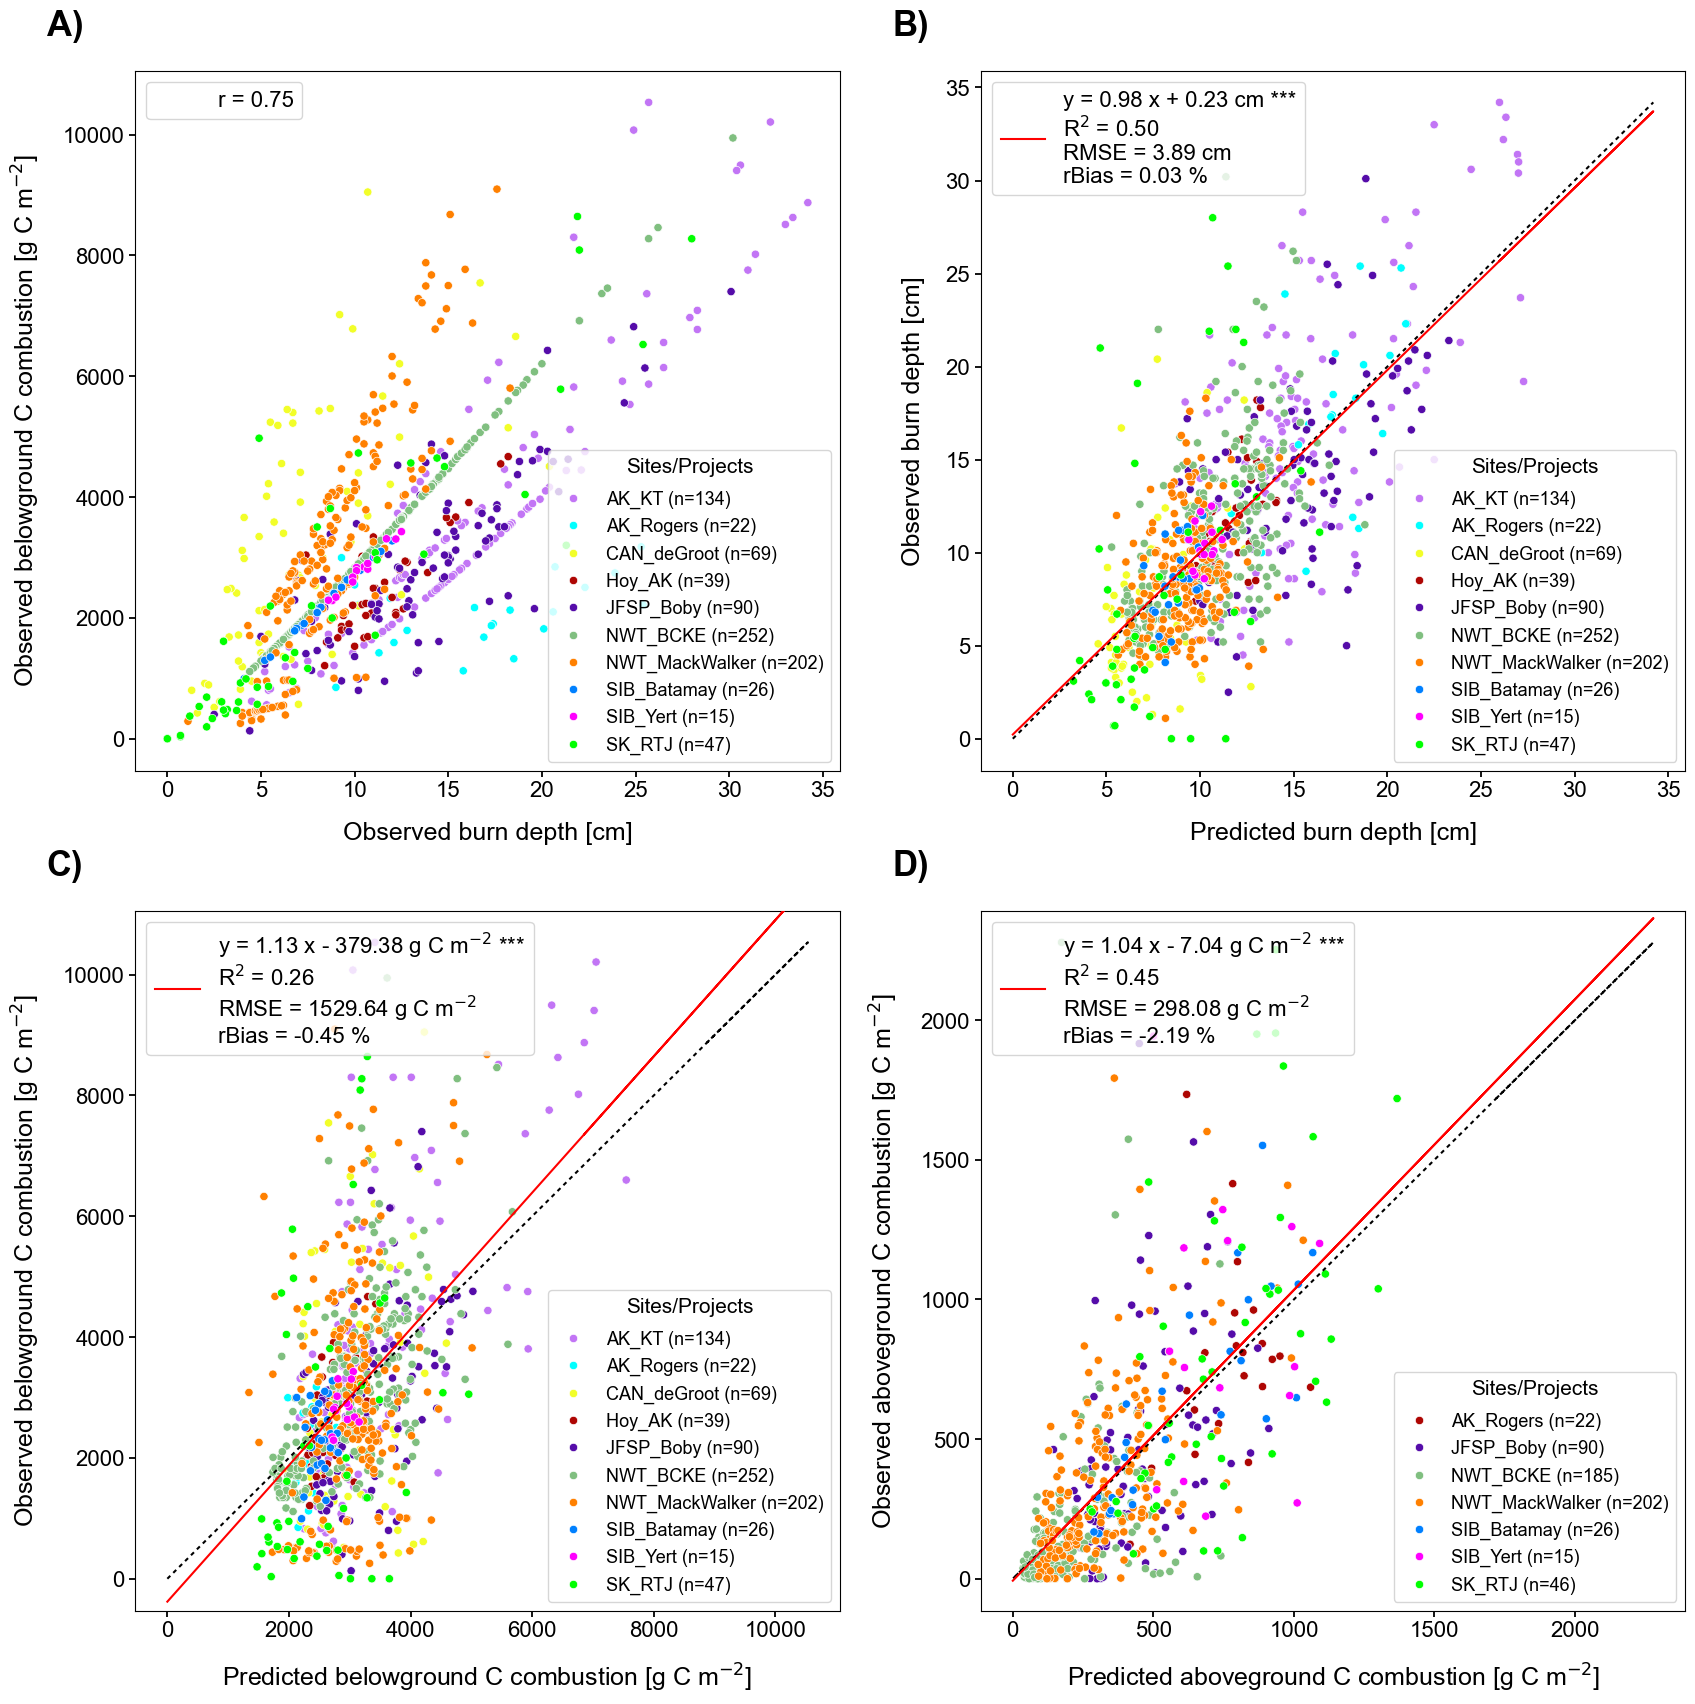

In [23]:
lab_dict = {
            'Ref': ['burn_depth', 'bg_c_combusted', 'Observed burn depth [cm]', 'Observed belowground C combustion [g C m$^{-2}$]'],
            'Depth': ['pred_depth', 'burn_depth', 'Predicted burn depth [cm]', 'Observed burn depth [cm]'],
            'BGCC': ['pred_bgc', 'bg_c_combusted', 'Predicted belowground C combustion [g C m$^{-2}$]', 
                     'Observed belowground C combustion [g C m$^{-2}$]'],
            'AGCC': ['pred_agcc', 'ag_c_combusted', 'Predicted aboveground C combustion [g C m$^{-2}$]', 
                     'Observed aboveground C combustion [g C m$^{-2}$]']
            }

fig, axes = plt.subplots(2, 2, figsize=(20, 20))
i = 0
for k, val in lab_dict.items():
    ax = axes.flatten()[i]
    data2 = data.copy()
    if k == 'AGCC':
        data2 = data2.query('ag_c_combusted >= 0 & ag_c_combusted < 5000')
    pred = data2[val[0]]
    obs = data2[val[1]]
    data2.sort_values(by=['project_name'], ascending=True, inplace=True)
    colors = distinctipy.get_colors(len(np.unique(data2.project_name)), rng=50)
    sns.scatterplot(data=data2, y=obs.name, x=pred.name, 
           marker='o', hue='project_name', ax=ax,
                    palette=reversed(colors)
                   )
    if k != 'Ref':
        ax.plot(obs, obs, color='black', linestyle='--', dashes=(2, 2))
    handles, labels = ax.get_legend_handles_labels()
    category_counts = data2['project_name'].value_counts()
    legend_labels = [f"{cat} (n={count})" for cat, count in category_counts[labels].items()]
    legend = ax.legend(handles=handles, labels=legend_labels, 
              title="Sites/Projects", loc="lower right",
             title_fontproperties={'size': 15},
                       fontsize=13
             ) 
    legend._legend_box.sep = 10

    ax.tick_params(labelsize = 16, size=4, width=1.3)
    ax.set_xlabel(val[2], size=18, labelpad=15, color='black')
    ax.set_ylabel(val[3], size=18, labelpad=15, color='black')
    unit = val[3].split('[')[1][:-1]
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(pred, obs)
    rmse = metrics.mean_squared_error(obs, pred, squared=False)
    bias = relative_bias(obs, pred)
    line = slope * pred + intercept
    pos_int = intercept >= 0
    ax2 = ax.twinx()
    ax2.set_ylim(ax.get_ylim())
    if k != 'Ref':
        mx = obs.max()
        label = 'y = %.2f x%s%s %.2f %s ***\nR$^2$ = %.2f\nRMSE = %.2f %s \nrBias = %.2f %s' %(
           slope, " +" * pos_int, " -" * (not pos_int), abs(intercept), unit, r_value**2, rmse, unit, bias, "%")
        c = 'r'
    else:
        mx = pred.max()
        label = 'r = %.2f' %(r_value)
        c = 'none'
    ax2.plot(np.insert(pred.values, [0, -1], [0, mx]), 
             np.insert(line.values, [0, -1], [intercept, slope * mx + intercept]), c, 
             label=label)
    leg1 = ax2.legend(loc="upper left", fontsize=16)
    ax2.axis('off'); 
    ax.text(-0.1, 1.05, f'{string.ascii_uppercase[i]})', transform=ax.transAxes, fontsize=25, fontweight='bold', ha='center')
    i += 1

    plt.savefig(f'{local_path}/Siberia/Plots/XGB_Results_byProject.jpeg', 
               dpi= 500, bbox_inches='tight', pad_inches=1*1/2.54)